In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
import shap
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
print(df.shape)
df.info()
df.isnull().sum()

(1470, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel     

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [ ]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [ ]:
df.drop(['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [ ]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       247
           1       0.32      0.53      0.40        47

    accuracy                           0.74       294
   macro avg       0.61      0.66      0.62       294
weighted avg       0.81      0.74      0.77       294



In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       247
           1       0.34      0.28      0.31        47

    accuracy                           0.80       294
   macro avg       0.60      0.59      0.59       294
weighted avg       0.78      0.80      0.79       294



In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       247
           1       0.44      0.34      0.39        47

    accuracy                           0.83       294
   macro avg       0.66      0.63      0.64       294
weighted avg       0.81      0.83      0.82       294



In [ ]:
cat_clf = CatBoostClassifier(verbose=0)
cat_clf.fit(X_train_res, y_train_res)
y_pred_cat = cat_clf.predict(X_test)
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       247
           1       0.44      0.38      0.41        47

    accuracy                           0.82       294
   macro avg       0.66      0.64      0.65       294
weighted avg       0.81      0.82      0.82       294



In [ ]:
from sklearn.metrics import roc_auc_score

models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb,
    "CatBoost": y_pred_cat
}

for name, pred in models.items():
    auc = roc_auc_score(y_test, pred)
    print(f"{name} ROC-AUC Score: {auc:.4f}")

Logistic Regression ROC-AUC Score: 0.6587
Random Forest ROC-AUC Score: 0.5877
XGBoost ROC-AUC Score: 0.6297
CatBoost ROC-AUC Score: 0.6449


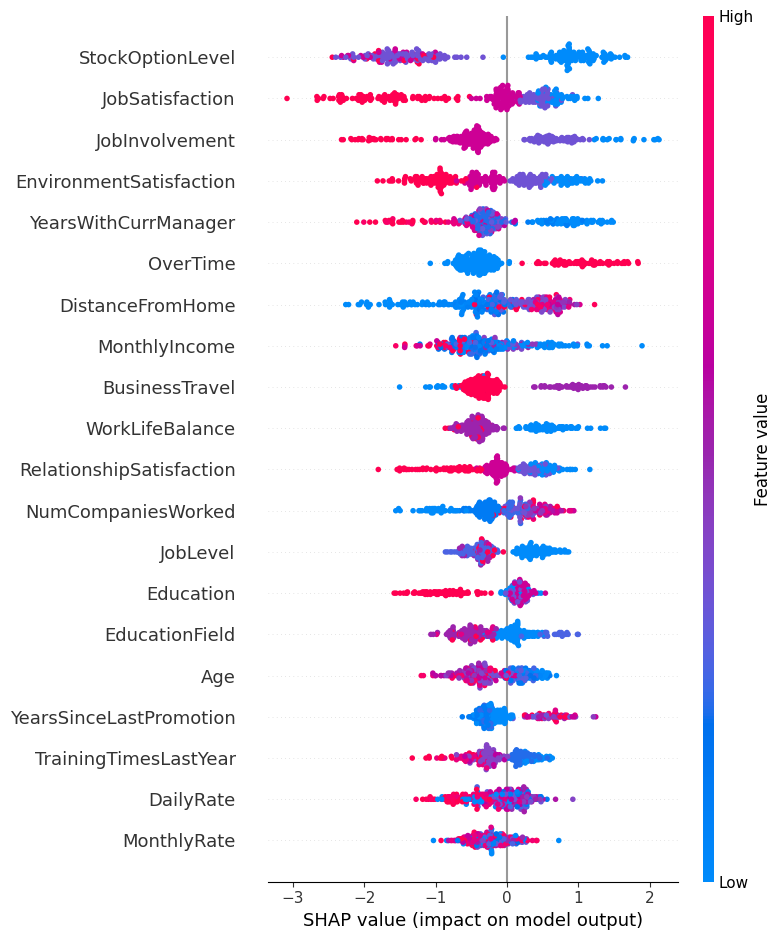

In [ ]:
explainer_xgb = shap.Explainer(xgb_clf)
shap_values_xgb = explainer_xgb(X_test)

shap.summary_plot(shap_values_xgb, X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0].values, X_test.iloc[0])

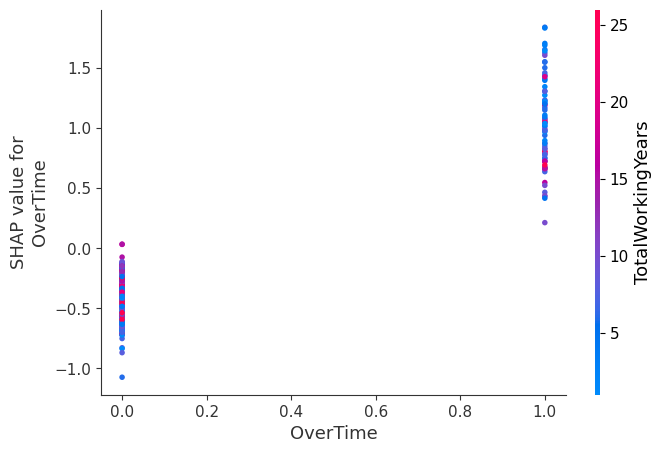

In [ ]:
shap.dependence_plot("OverTime", shap_values_xgb.values, X_test)

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9dbd1f8f58a8459e8ae2988e1653d1f6c333143e0dda264b5708d9f029920ae5
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_res),
    feature_names=X.columns,
    class_names=['No Attrition', 'Attrition'],
    mode='classification'
)

exp = explainer.explain_instance(X_test.iloc[1], xgb_clf.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

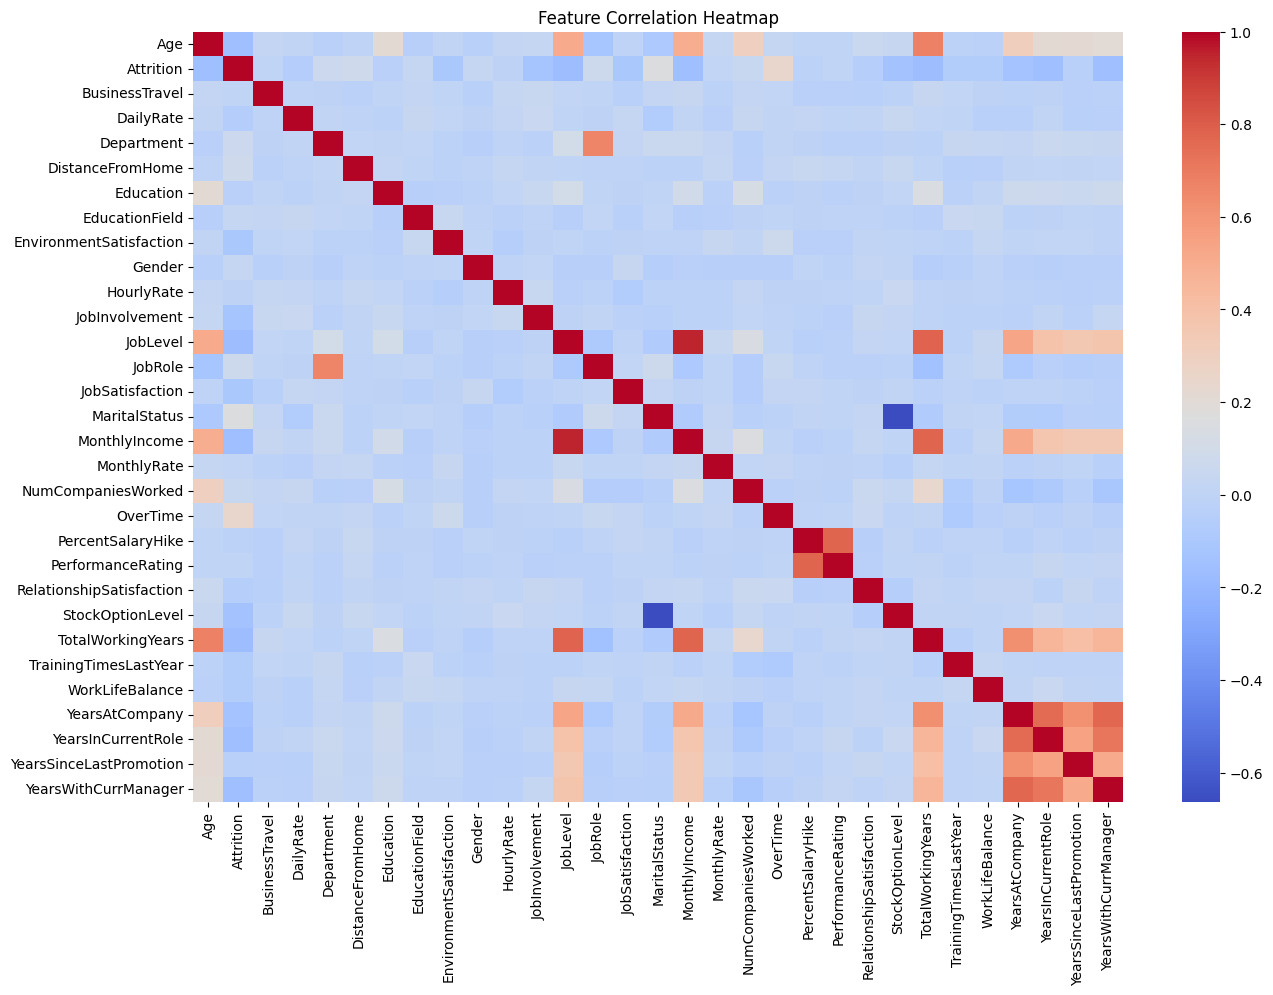

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

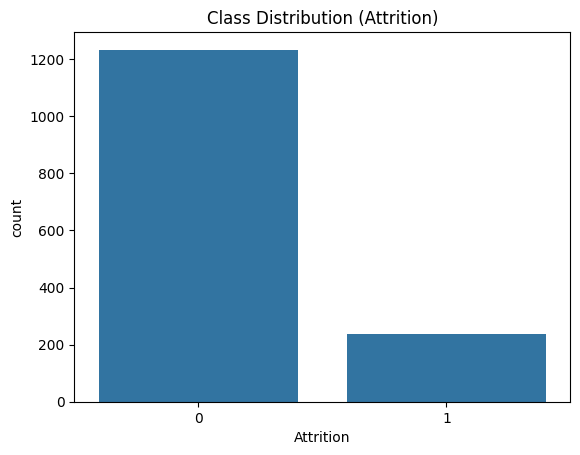

In [ ]:
sns.countplot(x='Attrition', data=df)
plt.title('Class Distribution (Attrition)')
plt.show()

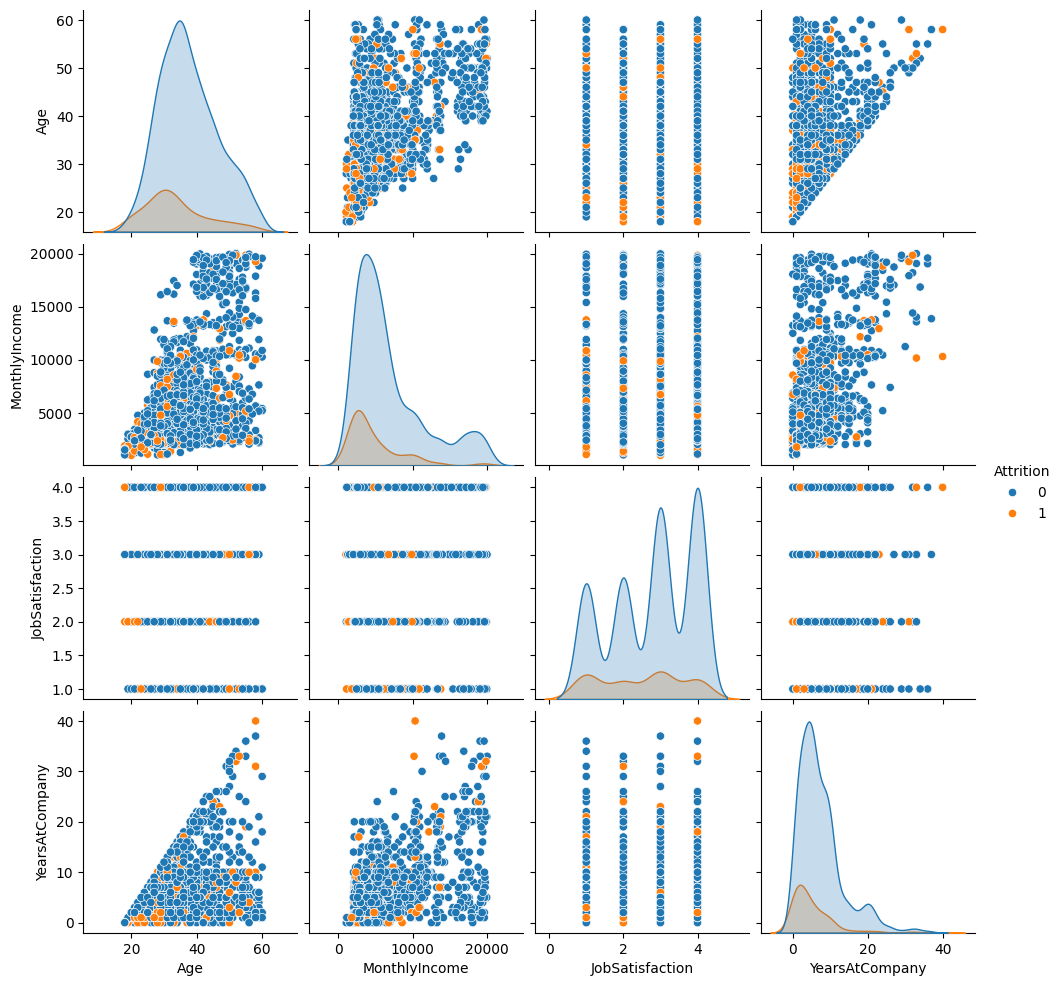

In [ ]:
sns.pairplot(df[['Age', 'MonthlyIncome', 'JobSatisfaction', 'YearsAtCompany', 'Attrition']], hue='Attrition')

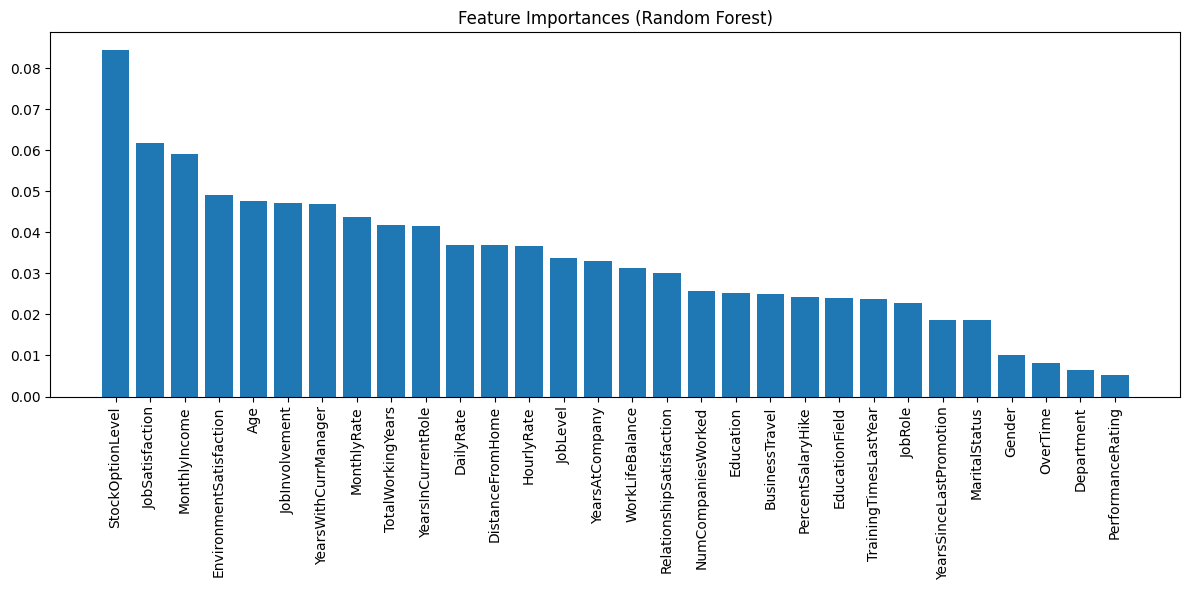

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(12, 6))
plt.title('Feature Importances (Random Forest)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

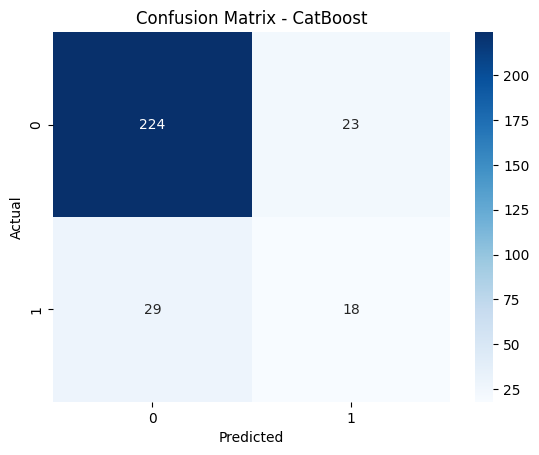

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CatBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

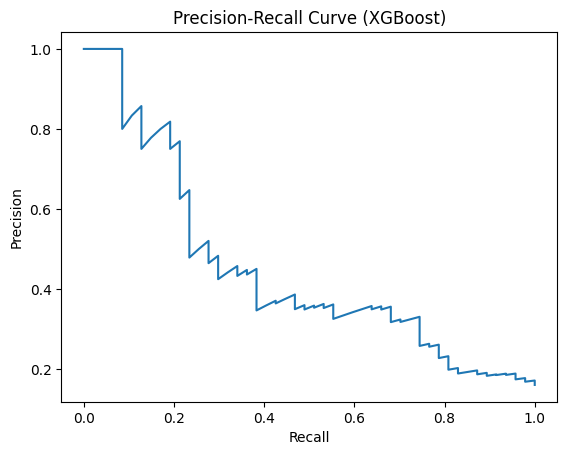

In [ ]:
from sklearn.metrics import precision_recall_curve
probs = xgb_clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, probs)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.show()

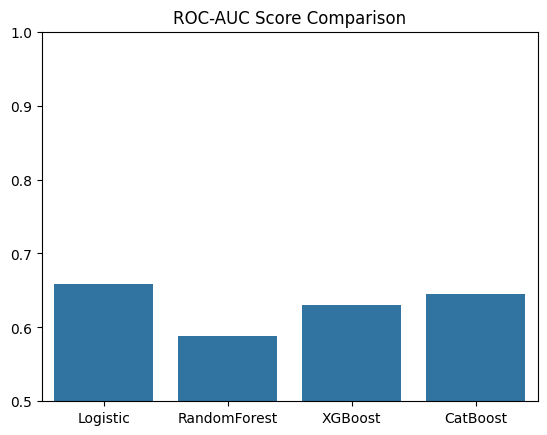

In [ ]:
scores = [
    roc_auc_score(y_test, y_pred_lr),
    roc_auc_score(y_test, y_pred_rf),
    roc_auc_score(y_test, y_pred_xgb),
    roc_auc_score(y_test, y_pred_cat)
]
model_names = ['Logistic', 'RandomForest', 'XGBoost', 'CatBoost']
sns.barplot(x=model_names, y=scores)
plt.title('ROC-AUC Score Comparison')
plt.ylim(0.5, 1.0)
plt.show()